In [1]:
import numpy as np
#import cupy as cp
#import sys
import time

from csr2d.beam_conversion import particle_group_to_bmad, bmad_to_particle_group
from pmd_beamphysics.plot import marginal_plot, density_plot
from csr2d.simple_track import track_a_bend, track_a_drift
from gathering.csr_kick import calc_csr_kick


import matplotlib.pyplot as plt
from pmd_beamphysics.plot import marginal_plot, density_plot

In [66]:
# fix random seed 
np.random.seed(0)

# Define a fake Gaussian beam 

# Number of macro particles
Np = 200000

sigma = 10E-6 
beam = np.random.normal(0, sigma , size=(6, Np))

beta_x = 5
emit_x = 0.5 * 1E-6 / 10000
sigma_x = np.sqrt(emit_x * beta_x)
sigma_xp = np.sqrt(emit_x**2 / sigma_x**2)  # to be fixed if <x xp> is nonzero

beam[0] = np.random.normal(0, sigma_x , size=(1, Np))
beam[1] = np.random.normal(0, sigma_xp , size=(1, Np))

#beam[0] = np.ones(Np)*1E-12
#beam[1] = np.ones(Np)*1E-12


beam[5] = np.zeros(Np)    # turn off initial pz

#Q = 160E-12
#Q = 1.602176634E-19 * 1e9
Q = 1.602176634E-19 * 1e9

charges = np.ones(Np)*Q/Np

gamma = 10000
beta = (1-1/gamma**2)**(1/2)

rho = 5

mc2 = 510998.950
P0c = gamma * beta * mc2  # in eV

# overtaking distance ( for Tao )
(24*sigma*rho**2)**(1/3)

0.181712059283214

In [3]:
W0 = 1e9* 2.8179403227E-15 * 510998.950 *(sigma/rho)**(2/3) / sigma**2

In [11]:
E = gamma*mc2

In [ ]:
# Introduce dispersion
eta =   0.02497917
etap = -0.09983342
beam[0] = beam[0] + eta  * beam[5]
beam[1] = beam[1] + etap * beam[5]

In [51]:
# Check beam optics
P = bmad_to_particle_group(beam, p0c = P0c, t_ref = 0, charges = charges, verbose=False)
P.twiss()

{'alpha_x': -0.0011124013436172857,
 'beta_x': 5.003607965764307,
 'gamma_x': 0.19985603274256475,
 'emit_x': 4.979575903932227e-11,
 'eta_x': 15856446.180111365,
 'etap_x': 4323309.803646395,
 'norm_emit_x': 4.979575879034348e-07}

In [ ]:
P.norm_emit_x

In [8]:
def projected_emit_x(beam):
    SS = np.cov(beam)
    s00 = SS[0][0] - SS[0][5]*SS[0][5] / SS[5][5]
    s01 = SS[0][1] - SS[0][5]*SS[1][5] / SS[5][5]
    s11 = SS[1][1] - SS[1][5]*SS[1][5] / SS[5][5]

    return np.sqrt(s00*s11 - s01**2)

In [ ]:
P.write_bmad('Yunhai_2dcsr_beam_Np200k.txt',p0c = P0c, t_ref = 0)

Depositting particles takes: 0.03255176544189453 s
Computing potential grids take: 2.213017702102661 s


In [ ]:
haha[]

In [67]:
# save the initial status
#data_vec = []
#data_vec2 = []
#data_vec3 = []
#data_vec4 = []

Plist = []
all_output = []
slist = [0]
s=0

P = bmad_to_particle_group(beam, p0c = P0c, t_ref = 0, charges = charges, verbose=False)
Plist.append(P)

#data_vec = np.append(data_vec, np.std(beam[4]))    
#data_vec = np.append(data_vec, P.norm_emit_x)
#data_vec2 = np.append(data_vec2, P.twiss()['beta_x'])
#data_vec3 = np.append(data_vec3, P.twiss()['eta_x'])
#data_vec4 = np.append(data_vec4, P.twiss()['norm_emit_x'])


for i in range(5):
    print("Running", i+1 , "th loop...")

    ds = 0.001

    ## track through a bend of length ds/2
    beam = track_a_bend(beam, P0c = P0c, L=ds/2, theta = ds/2/rho, g_err=0)

    ####===================================
    ## Calculate CSR kicks to xp and delta
  
    output = calc_csr_kick(beam, charges, Np, 10000, rho, Nz=200, sigma_z=sigma, Nx=200, sigma_x=sigma_x, verbose=True)
    
    ## Record output for analysis later
    all_output.append(output)
    
    delta_kick = output['delta_kick'] 
    beam[5] = beam[5] + delta_kick * ds
    
    #xp_kick = output['xp_kick'] 
    #beam[1] = beam[1] + xp_kick * ds
    
    ####====================================


    ## track through a bend of length ds/2
    beam = track_a_bend(beam, P0c = P0c, L=ds/2, theta = ds/2/rho, g_err=0)
    
    # save desired data every loop
    P = bmad_to_particle_group(beam, p0c = P0c, t_ref = 0, charges = charges, verbose=False)
    
    s += ds
    slist.append(s)
    Plist.append(P)
    #data_vec = np.append(data_vec, P.norm_emit_x)  
    #data_vec2 = np.append(data_vec2, P.twiss()['beta_x'])
    #data_vec3 = np.append(data_vec3, P.twiss()['eta_x'])
    #data_vec4 = np.append(data_vec4, P.twiss()['norm_emit_x'])

Running 1 th loop...
Depositting particles takes: 0.002585172653198242 s
Computing potential grids take: 2.9213664531707764 s
Running 2 th loop...
Depositting particles takes: 0.0027229785919189453 s
Computing potential grids take: 2.8005480766296387 s
Running 3 th loop...
Depositting particles takes: 0.0025169849395751953 s
Computing potential grids take: 2.842247724533081 s
Running 4 th loop...
Depositting particles takes: 0.002726316452026367 s
Computing potential grids take: 2.800163984298706 s
Running 5 th loop...
Depositting particles takes: 0.002610921859741211 s
Computing potential grids take: 2.835150957107544 s


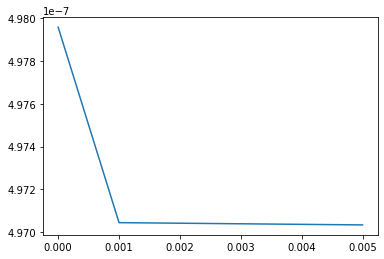

In [68]:
plt.plot(slist, [P.twiss()['norm_emit_x'] for P in Plist])

In [39]:
np.sum(charges)

1.6021766340000019e-10

In [5]:
r_e = 2.8179403227e-15 
Nb =  1e9
gamma=10000
kick_factor = r_e*Nb/gamma

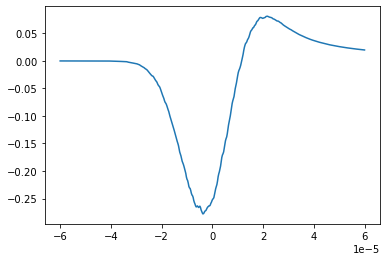

In [6]:
plt.plot(output['zvec'],output['Ws_grid'][:,250]* 1e3*kick_factor)

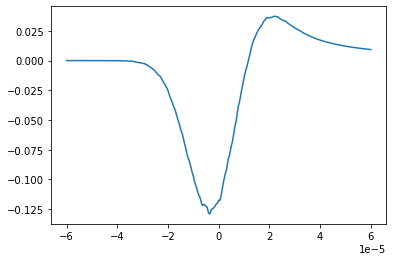

In [32]:
plt.plot(output['zvec'],output['Ws_grid'][:,250]* 1e3*kick_factor)

## Saving iles for analysis

In [23]:
np.save('Ws_grid_test.npy', output['Ws_grid'])
np.save('zvec.npy', output['zvec'])

In [ ]:
Ws_grid_list = np.array([all_output[i]['Ws_grid'] for i in range(len(all_output))

np.save( 'Ws_grid_1m_20steps_Np1000k_Nb500.npy', Ws_grid_list, allow_pickle=True)

In [17]:
Ws_grid_list = np.array([all_output[i]['Ws_grid'] for i in range(len(all_output))])

np.save( 'Ws_grid_1m_20steps_Np200k_Nb200.npy', Ws_grid_list, allow_pickle=True)

In [18]:
zvec_list = np.array([all_output[i]['zvec'] for i in range(len(all_output))])

np.save( 'zvec_1m_20steps_Np200k_Nb200.npy', zvec_list, allow_pickle=True)

In [ ]:
lala = np.load('Ws_grid_1m_100steps.npy')

## Plot projected emittance

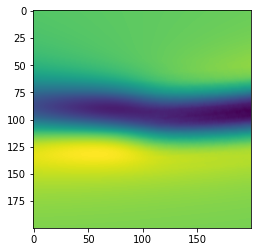

In [48]:
plt.imshow(all_output[0]['Ws_grid'])

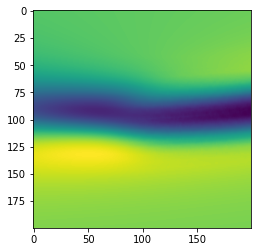

In [49]:
plt.imshow(all_output[-1]['Ws_grid'])

In [26]:
beamlist = [particle_group_to_bmad(P,p0c = P0c)[0] for P in Plist] 
pro_emit_x_list = [projected_emit_x(b)*gamma for b in beamlist]

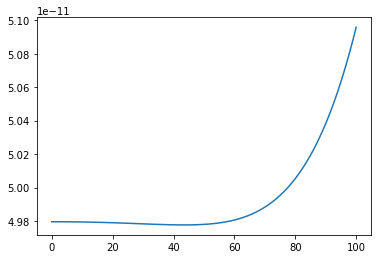

In [14]:
tao_pro_emit_x_list = np.loadtxt('/global/cfs/cdirs/m669/wlou1991/bmad_distributions/bmad_svn/tao/examples/simple_bend/pro_emit_x.dat')
plt.plot(tao_pro_emit_x_list)

In [ ]:
plt.plot(pro_emit_x_list)

In [ ]:
marginal_plot(Plist[100], 't', 'energy', bins=250)

In [ ]:
marginal_plot(Plist[100], 'x', 'xp', bins=250)

In [ ]:
from h5py import File
from pmd_beamphysics import ParticleGroup, particle_paths

In [21]:
from pmd_beamphysics import ParticleGroup, particle_paths
from h5py import File
filename = '/global/cfs/cdirs/m669/wlou1991/bmad_distributions/bmad_svn/tao/examples/simple_bend/beam_dump.h5'
with File(filename, 'r') as h5:
    ppaths = particle_paths(h5)
    PG = [ParticleGroup(h5[g]) for g in ppaths]
    
def get_stat(key):
    return [P[key] for P in PG]



In [32]:
pro_emit_x_list2 = [P.twiss()['norm_emit_x'] for P in Plist]

In [24]:
tao_pro_emit_x_list = [P.twiss()['norm_emit_x'] for P in PG]

In [34]:
lala = get_stat('norm_emit_x')  # Tao

In [36]:
kaka = [P['norm_emit_x'] for P in Plist]

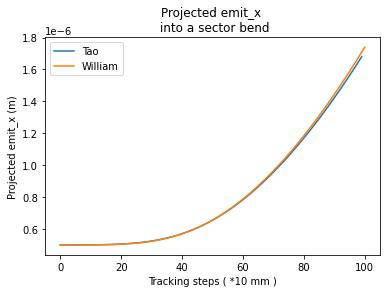

In [37]:
plt.plot(lala, label = 'Tao')
plt.plot(kaka, label = 'William')

plt.xlabel('Tracking steps ( *10 mm )')
plt.ylabel('Projected emit_x (m)')
plt.title('Projected emit_x \n into a sector bend')
plt.legend()

In [40]:
len(tao_pro_emit_x_list)

100

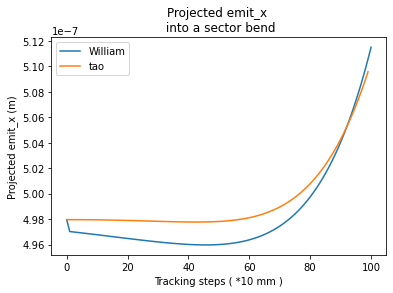

In [38]:
plt.plot(pro_emit_x_list, label = 'William')
plt.plot(tao_pro_emit_x_list, label = 'tao')

plt.xlabel('Tracking steps ( *10 mm )')
plt.ylabel('Projected emit_x (m)')
plt.title('Projected emit_x \n into a sector bend')
plt.legend()

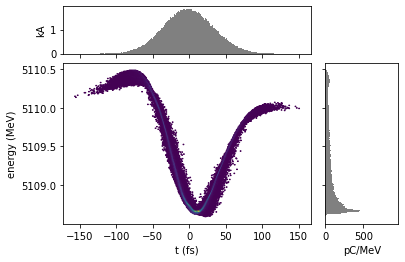

In [44]:
Plist[100].plot('t', 'energy', bins=250)

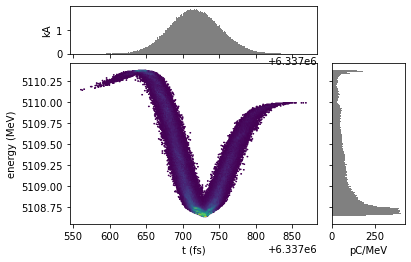

In [45]:
PG[100-1].plot('t', 'energy', bins=250)

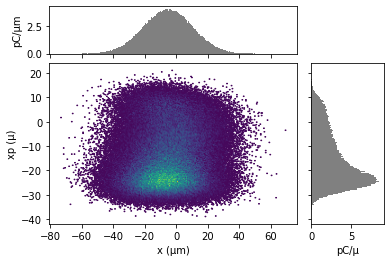

In [46]:
Plist[100].plot('x', 'xp', bins=250)

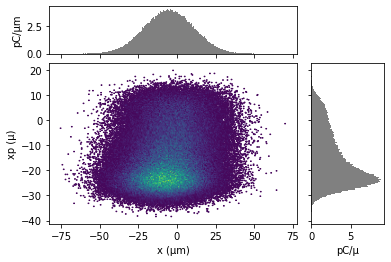

In [47]:
PG[100-1].plot('x', 'xp', bins=250)

In [ ]:
H5FILE  = '/global/cfs/cdirs/m669/wlou1991/bmad_distributions/bmad_svn/tao/examples/simple_bend/beam_END_1m_csron_zero_pz.hdf5'

# Load
h5 = File(H5FILE, 'r')
ppaths = particle_paths(h5)
ph5 = h5[ppaths[0]]

Ptao = ParticleGroup(ph5)

In [ ]:
marginal_plot(Ptao, 't', 'energy', bins=250)

In [ ]:
marginal_plot(Ptao, 'x', 'xp', bins=250)

In [ ]:
gamma

In [ ]:
twiss_list = [P.twiss('x') for P in Plist]

In [ ]:
plt.plot([t['norm_emit_x'] for t in twiss_list])

In [ ]:
plt.scatter(np.arange(len(data_vec4))*10, data_vec4) 
plt.xlabel('Tracking distance (mm)')
plt.ylabel('P.twiss()["norm_emit_x"] (m)')
plt.title('P.twiss()["norm_emit_x"]  \n into a sector bend')

In [ ]:
P.twiss(plane = 'x')

In [ ]:
P.norm_emit_x

In [ ]:
vec2 = np.append(vec2, data_vec[-1])  

In [ ]:
plt.scatter(np.arange(len(data_vec4))*10, data_vec4) 
plt.xlabel('Tracking distance (mm)')
plt.ylabel('P.twiss()["norm_emit_x"] (m)')
plt.title('P.twiss()["norm_emit_x"]  \n into a sector bend')

In [ ]:
plt.scatter(np.arange(len(data_vec2))*10, data_vec2) 
plt.xlabel('Tracking distance (mm)')
plt.ylabel('beta_x (m)')
plt.title('beta_x \n into a sector bend')

In [ ]:
plt.scatter(np.arange(len(data_vec3)-1)*10, data_vec3[1:]) 
plt.xlabel('Tracking distance (mm)')
plt.ylabel('eta_x (m)')
plt.title('eta_x \n into a sector bend')

In [ ]:
plt.scatter(np.arange(len(data_vec))*10, data_vec) 
plt.xlabel('Tracking distance (mm)')
plt.ylabel('norm_emit_x (m)')
plt.title('norm_emit_x \n into a sector bend')

In [ ]:
marginal_plot(P, 't', 'energy', bins=250)

In [ ]:
marginal_plot(P, 'x', 'xp', bins=250)

# Save and load multiple data for analysis

In [ ]:
# Name the file properly to avoid over-writting
np.savetxt("twiss_emitx_xp_kick_only_ds10mm_rho5m_beta5m_50steps.txt", data_vec4)

In [ ]:
d1 = np.loadtxt("emit_growth_no_csr_20steps.txt")
d2 = np.loadtxt("emit_growth_delta_kick_only_20steps.txt")
d3 = np.loadtxt("emit_growth_xp_kick_only_20steps.txt")
d4 = np.loadtxt("emit_growth_2d_csr_on_20steps.txt")

In [ ]:
plt.scatter(np.arange(20), d1, label='no csr')
plt.scatter(np.arange(20), d2, label='delta kick only')
plt.scatter(np.arange(20), d3, label='xp kick only')
plt.scatter(np.arange(20), d4, label='both kicks on')

plt.xlabel('Tracking distance (mm)')
plt.ylabel('norm_emit_x (m)')
plt.legend()
plt.title('Normalized horizontal emittance growth')

In [ ]:
d1 = np.loadtxt("sigma_z_no_csr_20steps.txt")
d2 = np.loadtxt("sigma_z_delta_kick_only_20steps.txt")
d3 = np.loadtxt("sigma_z_xp_kick_only_20steps.txt")
d4 = np.loadtxt("sigma_z_2d_csr_on_20steps.txt")

In [ ]:
plt.scatter(np.arange(21), d1, label='no csr')
plt.scatter(np.arange(21), d2, label='delta kick only')
plt.scatter(np.arange(21), d3, label='xp kick only')
plt.scatter(np.arange(21), d4, label='both kicks on')

plt.xlabel('Tracking distance (mm)')
plt.ylabel('sigma_z (m)')
plt.legend()
plt.title('Bunch length')